## 필요 라이브러리 설치
- einops: 텐서 차원 조작을 도와주는 라이브러리




In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


# 필요 라이브러리 import


In [2]:
import time
import urllib.request
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.layers import (
    Layer,
    LayerNormalization,
    Dropout,
    Embedding,
    Softmax
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, Loss
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Metric
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.math import rsqrt, minimum, argmax

from einops import rearrange, pack, unpack, einsum
from einops.layers.tensorflow import EinMix

# 챗봇 데이터 로드
- 출처: https://github.com/songys/Chatbot_data
  - 챗봇 트레이닝용 문답 페어 11,876개
  - 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
train_data['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

# 전처리 함수 구현

In [6]:
def preprocess_sentence(sentence):
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()

    return sentence

In [7]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = pad_sequences(
      tokenized_inputs,
      maxlen=MAX_LENGTH,
      padding='post'
  )
  tokenized_outputs = pad_sequences(
      tokenized_outputs,
      maxlen=MAX_LENGTH,
      padding='post'
  )

  return tokenized_inputs, tokenized_outputs

# 전처리 수행


## 질의응답 문장 전처리(1)
- 구두점 제거

In [8]:
questions = [preprocess_sentence(sentence) for sentence in train_data['Q']]
answers = [preprocess_sentence(sentence) for sentence in train_data['A']]

In [9]:
questions[:5]

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']

In [10]:
answers[:5]

['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']

## 단어집합 생성

In [11]:
# SubwordTextEncoder를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 2만큼 증가
VOCAB_SIZE = tokenizer.vocab_size + 2

In [12]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [13]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [14]:
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[10]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5779, 484, 194, 2984, 45, 3818]
기존 문장: SNS보면 나만 빼고 다 행복해보여


In [15]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# SubwordTextEncoder는 의미있는 단위의 서브워드로 토크나이징한다.
# 띄어쓰기 단위 X,  형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5779 ----> SNS
484 ----> 보면 
194 ----> 나만 
2984 ----> 빼고 
45 ----> 다 
3818 ----> 행복해보여


## 질의응답 문장 전처리(2)
- 토큰화
- 정수 인코딩
- 문장 시작 및 종료 토큰 추가
- 패딩

In [16]:
questions, answers = tokenize_and_filter(questions, answers)

In [17]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [18]:
# 7번째 샘플을 임의로 출력
print(questions[6])
print(answers[6])

[8178 8005 7990 2192  199 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178   69 2064  456    5  137 2188   17    1 8179    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [19]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


## 데이터셋 생성
- 올바른 번역 학습을 위하여 Teacher forcing 방법을 사용
- 따라서, 라벨을 따로 분리하여 저장

In [20]:
# Tensorflow dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한, 이 과정에서 Teacher forcing을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions[:, :-1],
        'dec_inputs': answers[:, :-1], # 디코더의 입력. 마지막 패딩 토큰이 제거된다.,
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    }
))

dataset = dataset.cache()    # 같은 데이터를 여러번 가져올 경우, 시간 감축을 위하여 캐싱 사용
dataset = dataset.shuffle(BUFFER_SIZE)   # 데이터 셔플링
dataset = dataset.batch(BATCH_SIZE)      # 배치 사이즈만큼, 데이터 적재
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)   # 모델 학습 시, 백그라운드 스레드를 이용하여 다음 step에 사용할 데이터 미리 적재

In [21]:
for data in dataset:
    print(data)
    break

{'inputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[8178,   28,   76, ...,    0,    0,    0],
       [8178,  715,  224, ...,    0,    0,    0],
       [8178, 1095,   80, ...,    0,    0,    0],
       ...,
       [8178, 3433,  207, ...,    0,    0,    0],
       [8178, 8156, 8102, ...,    0,    0,    0],
       [8178, 7002, 3121, ...,    0,    0,    0]], dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[8178, 1211,    1, ...,    0,    0,    0],
       [8178, 1681, 1475, ...,    0,    0,    0],
       [8178, 1255, 2941, ...,    0,    0,    0],
       ...,
       [8178, 3497,   93, ...,    0,    0,    0],
       [8178, 2976, 3298, ...,    0,    0,    0],
       [8178, 4161,  360, ...,    0,    0,    0]], dtype=int32)>, 'outputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[1211,    1, 8179, ...,    0,    0,    0],
       [1681, 1475, 1768, ...,    0,    0,    0],
       [1255, 2941,   10, ...,    0,    0,    0],
       ...,
  

# Transformer 구현
- Positional Encoding
- Multi-Head attention
- Encoder layer
- Encoder
- Decoder layer
- Decoder
- Transformer

## Positional Encoding

In [22]:
class PositionalEncoding(Layer):
  def __init__(
      self,
      position: int,
      embed_dim: int
  ):
      super(PositionalEncoding, self).__init__()
      self.pos_encoding = self.positional_encoding(position, embed_dim)

  def get_angles(
      self,
      position,
      idx,
      embed_dim: int
    ) -> EagerTensor:
      angles = 1 / tf.pow(10000, (2 * (idx // 2)) / tf.cast(embed_dim, tf.float32))
      return position * angles   # (position, embed_dim)

  def positional_encoding(
      self,
      position: int,
      embed_dim: int
    ) -> EagerTensor:
      angle_rads = self.get_angles(
          position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
          idx=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
          embed_dim=embed_dim
      )  # (position=sequence_len, embed_dim)

      # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
      sines = tf.math.sin(angle_rads[:, 0::2])

      # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
      cosines = tf.math.cos(angle_rads[:, 1::2])

      angle_rads = np.zeros(angle_rads.shape)
      angle_rads[:, 0::2] = sines
      angle_rads[:, 1::2] = cosines
      pos_encoding = tf.constant(angle_rads)   # (sequence_len, embed_dim)
      pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, sequence_len, embed_dim)

      return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
      return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]   # (batch_size, sequence_len, embed_dim)

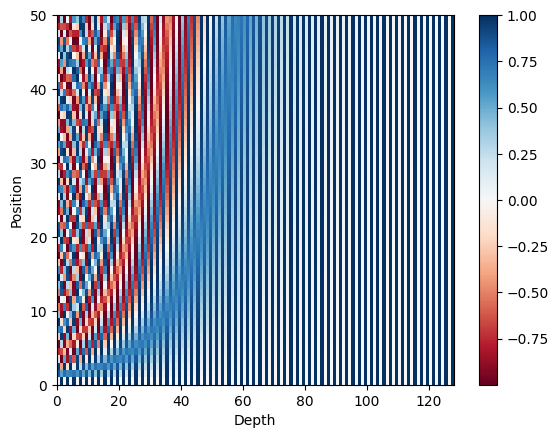

In [23]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [24]:
type(sample_pos_encoding.pos_encoding)

tensorflow.python.framework.ops.EagerTensor

## Multi-head attention

In [25]:
# 패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것입니다.
# 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.
def create_padding_mask(tensor):
    '''
    tensor: (batch_size, sequence_len)
    '''
    mask = tf.cast(tf.math.equal(tensor, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, key의 문장 길이)

In [26]:
class MultiHeadAttentionLayer(Layer):
  def __init__(
      self,
      embed_dim: int = 512,   # 임베딩 차원
      head_num: int = 8,      # 헤드 갯수
  ):
    super(MultiHeadAttentionLayer, self).__init__()
    self.head_num = head_num
    self.embed_dim = embed_dim

    assert self.embed_dim % self.head_num == 0

    self.mh_dim = self.embed_dim // self.head_num  # 멀티 헤드 어텐션 내 임베딩 차원

    # Dense layer와 기능이 같지만, tensor 입출력 구조를 손쉽게 확인 가능함
    self.to_query = EinMix(
      pattern='batch sequence dim_in -> batch sequence dim_out',
      weight_shape='dim_in dim_out',
      bias_shape='dim_out',
      dim_in=embed_dim,
      dim_out=embed_dim
    )

    self.to_key = EinMix(
      pattern='batch sequence dim_in -> batch sequence dim_out',
      weight_shape='dim_in dim_out',
      bias_shape='dim_out',
      dim_in=embed_dim,
      dim_out=embed_dim
    )

    self.to_value = EinMix(
      pattern='batch sequence dim_in -> batch sequence dim_out',
      weight_shape='dim_in dim_out',
      bias_shape='dim_out',
      dim_in=embed_dim,
      dim_out=embed_dim
    )

    # 멀티 헤드 어텐션 출력층에 대응하는 레이어
    self.dense = EinMix(
        pattern='batch sequence dim_in -> batch sequence dim_out',
        weight_shape='dim_in dim_out',
        bias_shape='dim_out',
        dim_in=embed_dim,
        dim_out=embed_dim
    )

  def call(
      self,
      query,
      key,
      value,
      mask
    ):
    '''
    query, key, value: (batch_size, sequence_len, embed_dim)
    mask: (batch_size, 1, 1, sequence_len)
    '''
    # 1. query, key, value 텐서 얻기
    query = self.to_query(query)
    key = self.to_key(key)
    value = self.to_value(value)

    # 2. query, key, value에 대해 멀티 헤드 텐서로 변경
    query, key, value = map(
        lambda x: rearrange(tensor=x, pattern='b s (h d) -> b h s d', h=self.head_num),
        (query, key, value)
    )  # (batch_size, multi-head_num, sequence_len, multi-head_embed_dim)

    # 3. dot product (query-key)
    energy = einsum(
        query,
        value,
        'b h q d, b h k d -> b h q k'
    )  # (batch_size, multi-head_num, sequence_len, sequence_len)

    # 4. scaled dot product
    scaled_energy = energy * self.mh_dim**-0.5   # (batch_size, multi-head_num, sequence_len, sequence_len)
    if mask is not None:  # mask는 패딩 마스크 또는 look-ahead 마스크 둘 중 하나
        scaled_energy += (mask * -1e9)

    # 5. attention score 계산
    attention_score = tf.nn.softmax(scaled_energy, axis=-1)  # (batch size, number of multi-head, sequence_len, sequence_len)

    # 6. attention vector 계산
    outputs = einsum(
        attention_score,
        value,
        'b h q k, b h k d -> b h q d'
    )  # (batch size, number of multi-head, sequence length, multi-head embed_dim)
    outputs = rearrange(
        outputs,
        pattern='b h q d -> b q (h d)'
    )  # (batch size, sequence length, embed_dim)

    # 7. Dense layer 통과 (for Residual connection)
    outputs = self.dense(outputs)


    return outputs  # (batch size, sequence length, embed_dim)

## Feed-forward

In [27]:
class FeedForwardLayer(Layer):
    def __init__(
        self,
        hidden_dim: int,
        embed_dim: int,
    ):
        super(FeedForwardLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        self.dense_1 = EinMix(
            pattern="batch sequence dim_in -> batch sequence dim_out",
            weight_shape="dim_in dim_out",
            bias_shape="dim_out",
            dim_in=embed_dim,
            dim_out=hidden_dim
        )
        self.dense_2 = EinMix(
            pattern="batch sequence dim_out -> batch sequence dim_in",
            weight_shape="dim_out dim_in",
            bias_shape="dim_in",
            dim_in=embed_dim,
            dim_out=hidden_dim
        )


    def call(
        self,
        inputs
    ):
        outputs = self.dense_1(inputs)
        outputs = self.dense_2(outputs)

        return outputs

## Encoder Layer

In [28]:
class EncoderLayer(Layer):
    def __init__(
        self,
        embed_dim: int = 512,       # 임베딩 차원
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율
    ):
        super(EncoderLayer, self).__init__()

        self.ff_layer_norm = LayerNormalization(axis=-1)
        self.mh_layer_norm = LayerNormalization(axis=-1)
        self.mh_attention = MultiHeadAttentionLayer(
            embed_dim=embed_dim,
            head_num=head_num
        )
        self.ff = FeedForwardLayer(
            hidden_dim=hidden_dim,
            embed_dim=embed_dim
        )
        self.dropout = Dropout(rate=dropout_ratio)

    def call(self, inputs, pad_mask):
        '''
        inputs: (batch_size, sequence_len, embed_dim)
        pad_mask: None or (batch_size, 1, 1, sequence_len)
        '''
        # multi-head attention
        mh_outputs = self.mh_attention(
            query=inputs,
            key=inputs,
            value=inputs,
            mask=pad_mask
        )
        # (batch_size, sequence_len, embed_dim)
        outputs = self.mh_layer_norm(self.dropout(mh_outputs) + inputs)

        # feed-forward propagation
        ff_outputs = self.ff(outputs)
        outputs = self.ff_layer_norm(self.dropout(ff_outputs) + outputs)

        return outputs    # (batch_size, sequence_len, embed_dim)

## Encoder

In [29]:
class Encoder(Layer):
    def __init__(
        self,
        vocab_size: int,
        sequence_len: int,
        layer_num: int,
        embed_dim: int,
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율
    ):
        super(Encoder, self).__init__(name='Encoder')

        self.embed_dim = embed_dim

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = PositionalEncoding(
            position=sequence_len,
            embed_dim=embed_dim
        )
        self.encoder_list = [
            EncoderLayer(embed_dim, head_num, hidden_dim, dropout_ratio)
            for _ in range(layer_num)
        ]



    def call(self, inputs):
        '''
        inputs: (batch_size, sequence_len)
        '''
        # positional encoding
        outputs = self.embedding(inputs)
        outputs *= tf.cast(self.embed_dim, tf.float32) ** -0.5
        outputs = self.pos_encoding(outputs)   # (batch_size, sequence_len, embed_dim)

        # generate padding mask
        pad_mask = create_padding_mask(tensor=inputs)    # (batch_size, 1, 1, sequence_len)

        # encoder layer
        for encoder in self.encoder_list:
            outputs = encoder(inputs=outputs, pad_mask=pad_mask)

        return outputs   # (batch_size, sequence_len, embed_dim)

## Decoder Layer

In [30]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(tensor):
    '''
    tensor: (batch_size, sequence_len)
    '''
    seq_len = tf.shape(tensor)[-1]
    # (sequence_len, sequence_len)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(tensor)   # (batch_size, 1, 1, sequence_len)

    # 패딩 마스크와 룩어헤드 마스크를 함께 고려
    # (batch_size, 1, sequence_len, sequence_len)
    return tf.maximum(look_ahead_mask, padding_mask)

In [31]:
class DecoderLayer(Layer):
    def __init__(
        self,
        embed_dim: int = 512,
        head_num: int = 8,
        hidden_dim: int = 2048,
        dropout_ratio: float = 0.3, # 드롭아웃 비율
    ):
        super(DecoderLayer, self).__init__()

        # masked multi-head attention layer norm
        self.mmh_layer_norm = LayerNormalization(axis=-1)
        # multi-head attention layer norm
        self.mh_layer_norm = LayerNormalization(axis=-1)
        # feed forward layer norm
        self.ff_layer_norm = LayerNormalization(axis=-1)

        # masked multi-head attention
        self.mmh_attention = MultiHeadAttentionLayer(
            embed_dim=embed_dim,
            head_num=head_num
        )
        # multi-head attention (Encoder-Decoder attention)
        self.mh_attention = MultiHeadAttentionLayer(
            embed_dim=embed_dim,
            head_num=head_num
        )
        # feed forward
        self.ff = FeedForwardLayer(
            hidden_dim=hidden_dim,
            embed_dim=embed_dim
        )
        self.dropout = Dropout(rate=dropout_ratio)


    def call(
        self,
        inputs,
        enc_output,
        look_ahead_mask,
        padding_mask
    ):
        '''
        inputs: (batch_size, sequence_len, embed_dim)
        enc_output: (batch_size, sequence_len, embed_dim)
        look_ahead_mask: (batch_size, 1, sequence_len, sequence_len)
        padding_mask: (batch_size, 1, 1, sequence_len)
        '''
        # masked multi-head attention
        mmh_outputs = self.mmh_attention(
            query=inputs,
            key=inputs,
            value=inputs,
            mask=look_ahead_mask
        )
        # (batch size, sequence length, embed_dim)
        mmh_outputs = self.mmh_layer_norm(self.dropout(mmh_outputs) + inputs)

        # multi-head attention
        mh_outputs = self.mh_attention(
            query=enc_output,
            key=enc_output,
            value=mmh_outputs,
            mask=padding_mask
        )
        mh_outputs = self.mh_layer_norm(self.dropout(mh_outputs) + mmh_outputs)

        # feed forward network propagation
        outputs = self.ff(mh_outputs)
        outputs = self.ff_layer_norm(self.dropout(outputs) + mh_outputs)

        return outputs  # (batch size, sequence length, embed_dim)


## Decoder

In [32]:
class Decoder(Layer):
    def __init__(
        self,
        vocab_size: int,
        sequence_len: int,
        layer_num: int,
        embed_dim: int,
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율
    ):
        super(Decoder, self).__init__(name='Decoder')

        self.embed_dim = embed_dim

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = PositionalEncoding(
            position=sequence_len,
            embed_dim=embed_dim
        )
        self.decoder_list = [
            DecoderLayer(embed_dim, head_num, hidden_dim, dropout_ratio)
            for _ in range(layer_num)
        ]


    def call(
        self,
        inputs,
        enc_output
    ):
        '''
        inputs: (batch_size, sequence_len)
        enc_output: (batch_size, sequence_len, embed_dim)
        '''
        # position embedding
        outputs = self.embedding(inputs)
        outputs *= tf.cast(self.embed_dim, tf.float32) ** -0.5
        outputs = self.pos_encoding(outputs)   # (batch_size, sequence_len, embed_dim)

        # generate look-ahead mask
        look_ahead_mask = create_look_ahead_mask(inputs)

        # generate padding mask
        padding_mask = create_padding_mask(inputs)

        # decoder layer
        for decoder in self.decoder_list:
            outputs = decoder(
                inputs=outputs,
                enc_output=enc_output,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

        return outputs   # (batch_size, sequence_len, embed_dim)


## Transformer

In [33]:
class Transformer(Model):
    def __init__(
        self,
        vocab_size: int,
        sequence_len: int,
        layer_num: int,
        embed_dim: int,
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율

    ):
        super(Transformer, self).__init__(name='Transformer')

        self.encoder = Encoder(
            vocab_size,
            sequence_len,
            layer_num,
            embed_dim,
            head_num,
            hidden_dim,
            dropout_ratio,
        )
        self.decoder = Decoder(
            vocab_size,
            sequence_len,
            layer_num,
            embed_dim,
            head_num,
            hidden_dim,
            dropout_ratio,
        )
        self.dense = EinMix(
            pattern='batch sequence dim_in -> batch sequence dim_out',
            weight_shape='dim_in dim_out',
            bias_shape='dim_out',
            dim_in=embed_dim,
            dim_out=vocab_size
        )

    def call(self, inputs):
        '''
        inputs: [(batch_size, sequence_len), (batch_size, sequence_len)]
        '''
        enc_output = self.encoder(inputs[0])
        # (batch_size, sequence_len, embed_dim)
        dec_output = self.decoder(inputs[1], enc_output)
        # (batch_size, sequence_len, vocab_size)
        outputs = self.dense(dec_output)
        outputs = Softmax(axis=-1)(outputs)

        return outputs  # (batch_size, sequence_len, vocab_size)

# Training

## 모델 생성

In [34]:
model = Transformer(
    vocab_size=VOCAB_SIZE,
    sequence_len=MAX_LENGTH,
    layer_num=3,
    embed_dim=512,
    head_num=8,
    hidden_dim=512,
    dropout_ratio=0.3
)

## Transformer 학습

### 손실 함수 정의

In [35]:
# 손실 함수 정의
class SCCELoss(Loss):
    def __init__(self):
        super(SCCELoss, self).__init__()
        self.scce_loss = SparseCategoricalCrossentropy(
            from_logits=False,
            reduction='none'
        )

    def call(self, y_true, y_pred):
        '''
        y_true: (batch_size, sequence_len)
        y_pred: (batch_size, sequence_len, vocab_size)
        '''
        y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

        # 패딩 값은 loss 계산 과정에서 제외해야 함!!
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)   # (batch_size, sequence_len)

        loss = self.scce_loss(y_true, y_pred)  # (batch_size, sequence_len)
        loss = tf.multiply(loss, mask)

        return tf.reduce_mean(loss)

In [36]:
loss = SCCELoss()

### 최적화 정의

In [37]:
# 스케쥴러 정의
# 해당 클래스를 상속받을 때는, 사전에 실수 형으로 cast해야 런타임 에러를 방지할 수 있음.
class CustomSchedule(LearningRateSchedule):
    def __init__(
        self,
        embed_dim: int = 512,
        warmup_steps: int = 5000
    ):
        super(CustomSchedule, self).__init__()
        self.embed_dim = tf.cast(embed_dim, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step_float = tf.cast(step, tf.float32)
        arg1 = rsqrt(step_float)
        arg2 = step_float * (self.warmup_steps**-1.5)

        return rsqrt(self.embed_dim) * minimum(arg1, arg2)

In [38]:
scheduler = CustomSchedule(embed_dim=512)

In [39]:
# 최적화 함수 정의
optimizer = tf.keras.optimizers.Adam(
    learning_rate=scheduler,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

### 평가 지표 정의

In [40]:
metric = SparseCategoricalAccuracy()

### 학습 함수 정의

In [41]:
def train(
    epochs,
    model,
    dataset,
    loss,
    optimizer,
    metric
):
    global_step = 0
    for epoch in range(epochs):
        for step, data in enumerate(dataset):
            enc_inputs = data['inputs']        # 인코더 입력 (batch_size, sequence_len)
            dec_inputs = data['dec_inputs']    # 디코더 입력 (batch_size, sequence_len)
            answers = data['outputs']          # 레이블 (batch_size, sequence_len)

            with tf.GradientTape() as tape:
                # transformer 통과
                probs = model(inputs=[enc_inputs, dec_inputs])  # (batch_size, sequence_len, vocab_size)

                # loss 계산
                losses = loss(answers, probs)

            # 역전파 수행
            trainable_vars = model.trainable_variables
            gradients = tape.gradient(losses, trainable_vars)

            # 파라미터 업데이트
            optimizer.apply_gradients(
                (grad, var)
                for (grad, var) in zip(gradients, model.trainable_variables)
                if grad is not None
            )

            if not step % 10:
                # 지표 계산
                answers = answers[:, :, tf.newaxis]  # (batch_size, sequence_len, 1)
                metrics = metric(answers, probs).numpy()

                # 동적 학습률 계산
                lr = optimizer.learning_rate.numpy()

                print(
                    f"[{epoch}/{epochs} epochs][{step}/{len(dataset)} steps]\t"
                    f"lr {lr:.4f}\t"
                    f"train loss {losses.numpy():.4f}\t"
                    f"train acc {metrics:.4f}"
                )

            global_step += 1

        print("=" * 100)


### 학습 수행

In [42]:
train(
    epochs=30,
    model=model,
    dataset=dataset,
    loss=loss,
    optimizer=optimizer,
    metric=metric
)

[0/30 epochs][0/185 steps]	lr 0.0000	train loss 1.5289	train acc 0.0000
[0/30 epochs][10/185 steps]	lr 0.0000	train loss 1.5486	train acc 0.0000
[0/30 epochs][20/185 steps]	lr 0.0000	train loss 1.6095	train acc 0.0000
[0/30 epochs][30/185 steps]	lr 0.0000	train loss 1.3043	train acc 0.0064
[0/30 epochs][40/185 steps]	lr 0.0000	train loss 1.3980	train acc 0.0103
[0/30 epochs][50/185 steps]	lr 0.0000	train loss 1.3447	train acc 0.0128
[0/30 epochs][60/185 steps]	lr 0.0000	train loss 1.1421	train acc 0.0147
[0/30 epochs][70/185 steps]	lr 0.0000	train loss 1.2904	train acc 0.0178
[0/30 epochs][80/185 steps]	lr 0.0000	train loss 1.2641	train acc 0.0187
[0/30 epochs][90/185 steps]	lr 0.0000	train loss 1.3205	train acc 0.0194
[0/30 epochs][100/185 steps]	lr 0.0000	train loss 1.3184	train acc 0.0201
[0/30 epochs][110/185 steps]	lr 0.0000	train loss 1.2101	train acc 0.0208
[0/30 epochs][120/185 steps]	lr 0.0000	train loss 1.3468	train acc 0.0218
[0/30 epochs][130/185 steps]	lr 0.0000	train loss